# Risk Modelling for Rent arrears
### By Ernesto Monroy, LiLib Koo, Oliver Mirnezami, Victor Torrent

## Summary

In this exercise, we attempt to use payment histories as well as postcode data to predict the risk of tenants falling into arrears in the next 6 months. The analysis carried out consisted of cleaning the imput data, engineering features, creating labels, testing different models and selecting the best. The analysis found that the Naive Bayes model was the most successful amongst 7 models tried with an accuracy of 85.27% a false positive score of 27.07% and a false negative score of 12.72%. It is important to note that although other models had better accuracy, this is the lowest false positive score. This given that we generally value higher reducing the missed high risk individuals than classifying low risk as high risk.

In addition to the 6 month evaluation of risk, we ran the same model using a 3 month horizon. We found that the second model obtained an accuracy of 92.86% a false positive score of 18.39% and a false negative score of 6.62%. We then concluded that short term risk is significantly more predictable than long term risk. Therefore, our recommendation to the landlords is to utilize short term predictions as much as possible when making decisions.

Considering the simplicity both of the measures and the data used in the model we set our hypothesis as finding a model that can acheive a generous false positive score lower than 30%. However, in order to take this analyisis further and improve the results we recommend two main actions. Firstly, it would be important to find additional sources of information for either the tenants or the different zip codes. Secondly,this analysis would benefit to try a larger amount of combinations of: models, hyperparameters and predictor combinations. 


### The Hypothesis

The objective of this exerise is to identify those individuals that pose a risk of significantly falling behind on their rent payments. This means that our hypothesis is based on the posibility of predicting high risk based on the data available to us, in this case, postcode and payment history. Our hypothesis is therefore:

__Given the history of payments for an individual at a specific point in time, it is possible to accurately estimate the probability of falling into arrears__

For the hypothesis, we will measure accuracy as: 1-false positive rate. This means that we place a higher value in accurately finding those high risk tenants over incorrectly classifying low risk as high risk. The reason is that given the high risk tenants are a considerably small proportion of the population (<5%) a model that prioritizes accuracy will tend to classify as many low risks as possible.

Finally, we will set the target of the hypothesis to be 70% of high risk payers correctly classified

### Rating of tenants

For our analysis we have established a two tier classification, high risk and low risk individuals. We have named the low risk label "A" and the high risk label "B". 

The main reason behind this choice, is that we consider that the decrease in accuracy is greater than the gain in information. This is, we would have a model that is less accurate, with more categories that are not easily actionable. In tha A/B scenario we can either accept the tenant into our property or not.

So in order to come up with a labelling criteria, we look at M months of data (6 and 3), and decide if we would have let the property to that client based on their payment history. More specifically, we look at two datapoints:
 - __Function form__: Is the customer improving, worsening stable
 - __Current debt__: We set 3 tiers worse than a maximum debt threshold, better than minimum debt threshold and in between.

The result is the following classification table

<table align="center">
  <tr>
    <th>Gradient</th>
    <th>Current debt greater <br> than max threshold </th>
    <th>Current debt between <br> mas and min threshold </th>
    <th>Current debt less <br> than min threshold </th>
  </tr>
  <tr>
    <th><img src="flat.png"> <br> Debt </th>
    <td>B</td>
    <td>A</td>
    <td>A</td>
  </tr>
  <tr>
    <th><img src="positive.png"> <br> Debt </th>
    <td>B</td>
    <td>A</td>
    <td>A</td>
  </tr>
  <tr>
    <th><img src="negative.png"> <br> Debt </th>
    <td>A</td>
    <td>A</td>
    <td>A</td>
  </tr>
  <tr>
    <th> <img src="concave.png"></th>
    <td>A</td>
    <td>A</td>
    <td>A</td>
  </tr>
  <tr>
    <th> <img src="convex.png"> </th>
    <td>A</td>
    <td>A</td>
    <td>A</td>
  </tr>
  <tr>
    <th> <img src="wigly.png"> </th>
    <td>B</td>
    <td>A</td>
    <td>A</td>
  </tr>
</table>


## Index to the Analysis

Aside from the Summary and Introduction, this notebook consists of the following sections:
 1. Loading Data and Libraries
 2. Data Cleaning and Exploring
  1. Postcode Data
  2. Date of Birth
  3. Payment Date
  4. Payment Ammount
  5. Rent Ammount
  6. Outstanding Balance
 3. Feature engineering
  1. Creating the risk label
  2. Deriving past data
  3. Merging postcode data
  4. Standardising
  5. Binarising
  6. Splitting the data
 3. Model Evaluation
  1. Naive Bayes
  2. Classification Tree
  3. K-Nearest Neighbor
  4. Support Vector Machines
  5. Random Forest
  6. Boosting
  7. Voting
 4. Model Comparison
 5. Comparing with shorter prediction horizon
 6. Conlcusions


## Loading Data and Libraries

### Libraries used
As standard, our main library sources are pandas and numpy for data handling; matplotlib and seaborn for visualization; and scikit learn's extensive ML offerings

In [208]:
#Data Handling
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
#Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()
#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
#Preprocessing and Accuracy
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_score

### Data Loading

The data used in this analysis consists of two sets. The first, is the payment history and postcodes for 1989 tenants.

The second set, is the summary of fillings for the IRS at postcode level. Its important to mention that given this analysis contains data between 2010 and 2012, we will use exclusively the IRS 2012 data set. In addition, we note that of the 32 fields available for the IRS dataset, we will only utilise: number of fillings, number of married fillings, earnings and wages.

#### Loading the rental set

In [209]:
#Load the data
df = pd.read_csv('rental_data.csv')
#Rename columns
df['house_id'] = df['houseID']
df['zip'] = df['houseZip']
df['rent'] = df['rentAmount']
df['payment_date'] = df['paymentDate_clean']
df['dob'] = df['dob_clean']
df['payment_amount'] = df['paymentAmount_clean']

#Keep names of columns of interest
rent_columns=['name','house_id','zip','rent','payment_date','dob','payment_amount']
#Keep columns of interest
df = df[rent_columns]
df.head(5)

,name,house_id,zip,rent,payment_date,dob,payment_amount
0,Paulina Lefort,1869,92129,1324.0,2010-01-02,NaN,1324.0
1,Clare Tilly,407,92155,1723.0,2010-01-02,NaN,1723.0
2,Eleni Loudin,647,92111,1494.0,2010-01-02,2000-01-01,1494.0
3,Tandy Ammann,2215,92153,1438.0,2010-01-02,1992-12-02,1438.0
4,Tamra Trisler,2213,92172,1658.0,2010-01-02,2000-01-01,1658.0


#### Loading the IRS set

The data set used here has been preprocessed by a python script. This is because the original dataset contained information about all the US and we are only interested in 32 postcodes in California. The python script is attached to this notebook.

In [210]:
#Load the data
df_geo= pd.read_csv('poscodes_processed.csv')
#Get the normalized data of interest
df_geo['population'] = StandardScaler().fit_transform(df_geo['N1'].values.reshape(-1, 1))
df_geo['earnings'] = StandardScaler().fit_transform(df_geo['A00100'].values.reshape(-1, 1))
df_geo['salaries'] = StandardScaler().fit_transform(df_geo['A00200'].values.reshape(-1, 1))
df_geo['marriages'] = df_geo['MARS2']/df_geo['N1']
df_geo=df_geo[['ZIPCODE','population','earnings','salaries','marriages']]
df_geo.head(5)

,ZIPCODE,population,earnings,salaries,marriages
0,92101,-0.121627,0.329478,0.262245,0.180435
1,92102,-0.089934,-0.936844,-0.853826,0.245840
2,92103,-0.021037,0.375669,0.065237,0.201255
3,92104,0.641754,-0.250251,-0.046980,0.196324
4,92105,1.101988,-0.739703,-0.614150,0.284457


## Data cleaning & exploring

In this section we explore the data available by means of histograms and means and begin deciding which features we will use in our model.

### Postcode Data

In the previous step we loaded and standardised the postcode data, in this part, we look at the distribution of values for each of our 4 candidate columns and decide which to include. From the below histograms we observe that all of the variables offer a wide distribution of values (i.e. there is no highly skewed data) and we decide to keep the variables for the next step of analysis

Text(0.5, 0, 'marriages')

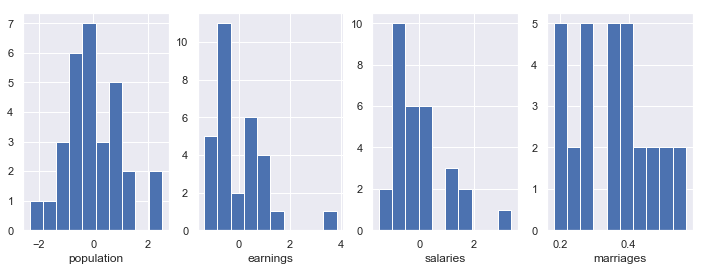

In [211]:
figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.hist(df_geo['population']);
plt.xlabel('population')
plt.subplot(1,4,2)
plt.hist(df_geo['earnings']);
plt.xlabel('earnings')
plt.subplot(1,4,3)
plt.hist(df_geo['salaries']);
plt.xlabel('salaries')
plt.subplot(1,4,4)
plt.hist(df_geo['marriages']);
plt.xlabel('marriages')

### Date of Birth
Population data seems to be badly inputed, so we will convert to None any DOB that is more than 18 years from the maximum payment date (When the data stops), and less than 100 years from that same date. However, there is only data for 16% of the population, so we __will exclude it from our analysis__ (_check if this is ok?? we could also trim the sides and "move it"_)

Average dob year: 1993 and max payment date (data present year): 1  2012


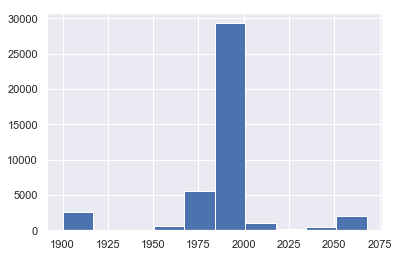

In [212]:
unique_dob_years=df['dob'][pd.isnull(df['dob'])==False]
unique_dob_years=unique_dob_years.str.slice(start=0,stop=4).astype(np.int)
plt.hist(unique_dob_years);
print("Average dob year: %d and max payment date (data present year): %d " % (
    unique_dob_years.mean(),1),
      df['payment_date'].str.slice(start=0,stop=4).astype(np.int).max())

### Payment date

Since we are given the payment date as string (as XXXX-XX-XX) with no further information, we need to deduce the possible date format. We begin by exploring the distribution of the second and third numbers in the string (since we know that the first is definetly the year due to being 4 digits)

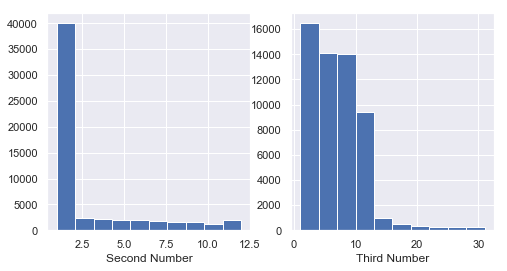

In [213]:
figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(df['payment_date'].str.slice(start=5,stop=7).astype(np.int));
plt.xlabel('Second Number');
plt.subplot(1,2,2)
plt.hist(df['payment_date'].str.slice(start=8,stop=10).astype(np.int));
plt.xlabel('Third Number');

Here we notice two important trends. On the "second number" there is a big skew towards the number "1" as well as a distribution limited by 12. This indicates that either, there are mixed dates, or the great majority of payments are made in January. 

We also notice a similar trend for the third number, where we get up to the number 31 and a high skew on the first 12 numbers. Indicating also that there is a mix of dates (or the unlikely scenario that there is a significant drop in payments after the 12th day of the month).

So in order to make this information useable, we must determine the correct format for each row. Looking at the data individually (in a table) we observe that at least the date formating is consistent at the "House ID" level (i.e. the format is consistent for all payments against each house id).

Therefore we proceed to clean the data by looking at all the payment dates per house ID. More specifically we apply the following rules in order (i.e. if rule 1 identifies the date format we stop):
 - __The date being valid__ If we have an impossible month (>12) we automatically classify it
 - __Months being consecutively after each other__ e.g.if we have 01/02, 01/03, 01/04 we assume the month is the one changing. We do this by assigning a score of 1 if the months are consecutive, 0 if they are the same and -1 if they are going backward.
 - __Payments distributed through months__ i.e, we check how many unique months we get by applying each format
 - __Shortest tenancy__ Since this is the fourth rule, only the cases that have <3 datapoints will end here. In this case, we assume the tenancy is as short as possible (i.e. we assign the class of the format that minimises the sum of difference between dates)
 

In [214]:
#Create a column for the dates for each format
df['month_ydm'] = pd.to_datetime(df['payment_date'], 
                                 format='%Y-%d-%m', errors='coerce').values.astype('datetime64[M]')
df['month_ymd'] = pd.to_datetime(df['payment_date'], 
                                 format='%Y-%m-%d', errors='coerce').values.astype('datetime64[M]')
#Get the lag (i.e. the date of the previous datapoint (by house_id))
df['month_lag_ydm']=  df.groupby(['house_id'])['month_ydm'].shift(1)
df['month_ymd_lag']=  df.groupby(['house_id'])['month_ymd'].shift(1)
#Add column for UK and US where -1= before, 0= same, 1=next
df['ydm_score']=(df['month_ydm']>df['month_lag_ydm']).astype(np.float32)
-(df['month_ydm']<df['month_lag_ydm']).astype(np.float32)
df['ymd_score']=(df['month_ymd']>df['month_ymd_lag']).astype(np.float32)
-(df['month_ymd']<df['month_ymd_lag']).astype(np.float32)
#If the date is invalid, assign an arbitrarily large negative number so we never pick it
df['ymd_score'][pd.isnull(df['month_ymd'])]=-999
df['ydm_score'][pd.isnull(df['month_ydm'])]=-999
#Add column for difference between days
df['ydm_delta']=  (df['month_ydm']-df['month_lag_ydm'])/np.timedelta64(1, 'D')
df['ymd_delta']=  (df['month_ymd']-df['month_ymd_lag'])/np.timedelta64(1, 'D')

#Aggregate the data by house
date_type= df.groupby('house_id', as_index=False).agg({
    'ydm_score':sum,
    'ymd_score':sum,
    'month_ydm':pd.Series.nunique,
    'month_ymd':pd.Series.nunique,
    'ydm_delta':sum,
    'ymd_delta':sum
})

#Define a function that classifies our data
def is_date_us(row):
  if row['ydm_score'] > row['ymd_score']:
    return True
  elif row['ydm_score'] < row['ymd_score']:
    return False
  else:
    if row['month_ydm'] > row['month_ymd']:
      return True
    elif row['month_ydm'] < row['month_ymd']:
      return False
    else:
      return row['ydm_delta'] < row['ymd_delta']
    
#Apply the function
date_type['is_date_ydm']=date_type.apply(is_date_us, axis=1)
date_type.head(5)

,house_id,ydm_score,ymd_score,month_ydm,month_ymd,ydm_delta,ymd_delta,is_date_ydm
0,1,2.0,30.0,3,31,730.0,943.0,False
1,2,-16978.0,20.0,12,21,853.0,1004.0,False
2,3,29.0,3.0,31,4,943.0,730.0,True
3,4,28.0,3.0,30,4,820.0,761.0,True
4,5,-981.0,20.0,29,21,518.0,1035.0,False


Now that we have determined if the date is YdM (i.e. if not it is YmD). We can transform our source data

In [215]:
#Merge with original data set
df=df.merge(date_type[['house_id','is_date_ydm']])
#Apply Ymd Date to all
df['new_date'] = pd.to_datetime(df['payment_date'], format='%Y-%m-%d', errors='coerce')
#Except for those that are Ydm (override)
df['new_date'][df['is_date_ydm']] = pd.to_datetime(df['payment_date'], format='%Y-%d-%m', errors='coerce')
df['payment_date']=df['new_date']
#Reduce columns to our normal
df=df[rent_columns]
df.head(5)

,name,house_id,zip,rent,payment_date,dob,payment_amount
0,Paulina Lefort,1869,92129,1324.0,2010-02-01,NaN,1324.0
1,Paulina Lefort,1869,92129,1324.0,2010-03-01,NaN,1324.0
2,Paulina Lefort,1869,92129,1324.0,2010-04-01,NaN,1324.0
3,Paulina Lefort,1869,92129,1324.0,2010-05-01,NaN,1324.0
4,Paulina Lefort,1869,92129,1324.0,2010-06-01,NaN,1324.0


### Payment amount

An important feature of the data set, is that we only get the data when a payment is made, but we have no datapoints for payments being due. Therefore we need to create our own data for payments owed. We do this by assuming that every month, the tentant must pay their rent. We consider that the tenancy of each person starts on the month of their first payment and ends in the month of their last payments.

Therefore, we proceed to create monthly snapshots of each tenant. We aggregate the rent paid, average the payment amount (since sometimes they change from one house to another) and record the first house (the outgoing house)

Since there are months where tenants dont pay, we need to derive the rent owed from the previous row for that specific tenant. We do this with the lag function that updates the rent with the rent from the previous row. The loop here is needed since there may be many months unpaid, in which case, it will loop until there are no more nulls.

It is also worth mentioning that the resample function creates a datapoint for each "month start" (or MS) for all months between the minimum and maximum observed month. This means we get a datapoint for every month between the first and last payment, which we assume is the tenancy period

In [216]:
df=df.set_index('payment_date').groupby('name').resample("MS").agg({
    'rent':'mean',
    'payment_amount': 'sum',
    'house_id':'first',
    'zip':'first'
})
df=df.reset_index()
#Replace NaN rent amounts (since average of nothing is NaN) with previous rent until there is none missing
while len(df['rent'][pd.isnull(df['rent'])])>0:
  df['lag_rent']=df.groupby(['name'])['rent'].shift(1)
  df['rent'].fillna(df['lag_rent'], inplace=True)
  df['lag_house_id']=df.groupby(['name'])['house_id'].shift(1)
  df['house_id'].fillna(df['lag_house_id'], inplace=True)
  df['lag_zip']=df.groupby(['name'])['zip'].shift(1)
  df['zip'].fillna(df['lag_zip'], inplace=True)
  
df=df[['name','house_id','zip','payment_date','rent','payment_amount']]
df.head(5)

,name,house_id,zip,payment_date,rent,payment_amount
0,Aaron Huston,1.0,92194.0,2010-02-01,1720.0,1720.0
1,Aaron Huston,1.0,92194.0,2010-03-01,1720.0,1720.0
2,Aaron Huston,1.0,92194.0,2010-04-01,1720.0,1720.0
3,Aaron Huston,1.0,92194.0,2010-05-01,1720.0,1720.0
4,Aaron Huston,1.0,92194.0,2010-06-01,1720.0,1720.0


And now we visualise the newly created information on a histogram and observe a healthy logarithmic distribution with a set of points with missed payments as expected

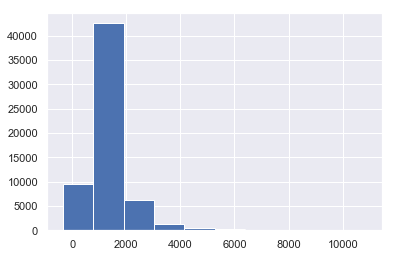

In [217]:
plt.hist(df['payment_amount']);

### Rent amount

In the below histogram we can see that there is a good distribution of rent amounts, we we will not adjust it

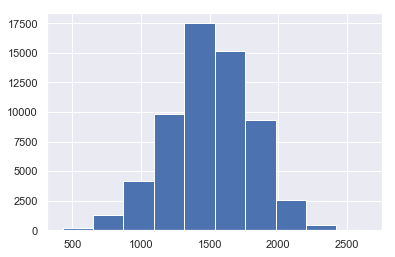

In [218]:
plt.hist(df['rent']);

### Calculate outstanding balance

Now that we have a clean history of monthly patments we calculate the cumulative amounts for payments outstanding and months outstanding. 

The standard through this notebook is __positive numbers indicate debt is owed__ and viceversa __negative numbers indicate overpayment__

It is also important to note that we avoid __data peeking__ by making cumulative sums. When creating historical columns for prediction, we maintain this principle of always looking back in time only.

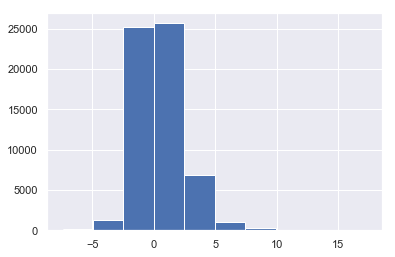

In [219]:
#Calculate if the rent was under over paid
df['outstanding_payment']=df['rent']-df['payment_amount']
df['outstanding_month']=df['outstanding_payment']/df['rent']
#Then do the cumulative sum
df['owed']=df.groupby('name')['outstanding_payment'].cumsum()
df['owed_months']=df.groupby('name')['outstanding_month'].cumsum()
#Reduce columns
df=df[['name','house_id','zip','payment_date','rent','payment_amount','owed','owed_months']]
#Check the distribution
plt.hist(df['owed_months'],10);

## Feature engineering

Now we take the data we have as a base to calculate new features that can be used in our models. We are concerned about getting information about:
 - Historical data: since each data point is a month for a single person, we want to know what happened before and after
 - Serialising: We will attempt to use both regression and classification models, so where approriate we will want to use either a serialised or non-serialised value for each column of data we got


### Create the Y

As introduced previously, we would like to classify clients into 2 categories acording to the slope and latest debt. Given the data seen in the previous histogram, we consider. For the purposes of this exercies we have established the minimum threshold as __0 months owed__ and for the maximum threshold we have established __4 months owed__

The first step towards the classification is to generate M columns of timeseries data. This is, for each month, we will look at what are the balances of the future 6 and 3 months. Here we take the __future__ months since this is what we want to __predict__

In [220]:
timeseries_columns=[]
for i in range(1,7): #For 6 months in the future
  timeseries_columns+=['t'+str(i)]
  df['t'+str(i)]=df.groupby(['name'])['owed_months'].shift(-(i))
#remove missing data (columns that are less than 6 months from final month of tenancy) 
df = df.dropna()
df.head(8)

,name,house_id,zip,payment_date,rent,payment_amount,owed,owed_months,t1,t2,t3,t4,t5,t6
0,Aaron Huston,1.0,92194.0,2010-02-01,1720.0,1720.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aaron Huston,1.0,92194.0,2010-03-01,1720.0,1720.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Aaron Huston,1.0,92194.0,2010-04-01,1720.0,1720.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,Aaron Huston,1.0,92194.0,2010-05-01,1720.0,1720.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,Aaron Huston,1.0,92194.0,2010-06-01,1720.0,1720.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,Aaron Huston,1.0,92194.0,2010-07-01,1720.0,1720.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
6,Aaron Huston,1.0,92194.0,2010-08-01,1720.0,1720.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
7,Aaron Huston,1.0,92194.0,2010-09-01,1720.0,0.0,1720.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [223]:
#backup=df
df=backup

Now we create a couple of functions to classify our data.

In [224]:
#Define a function that classifies our data
def credit_score(row):
  #Max and min Threshold for debt
  low_threshold=0
  high_threshold=4
  min_value=row[timeseries_columns].min()
  max_value=row[timeseries_columns].max()
  start_value=row[timeseries_columns[0]]
  last_value=row[timeseries_columns[-1]]
  #If slope is flat
  if (min_value == max_value):
    if last_value>=high_threshold:
      return "B"
    elif last_value>=low_threshold:
      return "A"
    else:
      return "A"
  #If slope is positive (getting more debt)
  elif (min_value == start_value) and (max_value == last_value):
    if last_value >= high_threshold:
      return "B"
    elif last_value >= low_threshold:
      return "A"
    else:
      return "A"
  #If slope is negative (decreasing debt)
  elif (min_value == last_value) and (max_value == start_value):
    if last_value >= high_threshold:
      return "A"
    elif last_value >= low_threshold:
      return "A"
    else:
      return "A"
  #If concave
  elif (max_value != start_value) and (max_value != last_value) and (min_value == last_value or min_value == start_value):
    if last_value >= high_threshold:
      return "A"
    elif last_value>=low_threshold:
      return "A"
    else:
      return "A"
  #If convex
  elif (min_value != start_value) and (min_value != last_value) and (max_value == last_value or max_value == start_value):
    if last_value >= high_threshold:
      return "A"
    elif last_value >= low_threshold:
      return "A"
    else:
      return "A"
  #If wigly
  else:
    if last_value>=high_threshold:
      return "B"
    elif last_value >= low_threshold:
      return "A"
    else:
      return "A"
    
#Apply the function
df['credit_score']=df.apply(credit_score, axis=1)
#Change the columns in the function to only 3 months and apply again
timeseries_columns=['t1','t2','t3']
df['credit_score_short']=df.apply(credit_score, axis=1)

#Reduce the columns
df=df[['name','house_id','zip','payment_date','rent','owed','owed_months','credit_score','credit_score_short']]
df.head(5)

,name,house_id,zip,payment_date,rent,owed,owed_months,credit_score,credit_score_short
0,Aaron Huston,1.0,92194.0,2010-02-01,1720.0,0.0,0.0,A,A
1,Aaron Huston,1.0,92194.0,2010-03-01,1720.0,0.0,0.0,A,A
2,Aaron Huston,1.0,92194.0,2010-04-01,1720.0,0.0,0.0,A,A
3,Aaron Huston,1.0,92194.0,2010-05-01,1720.0,0.0,0.0,A,A
4,Aaron Huston,1.0,92194.0,2010-06-01,1720.0,0.0,0.0,A,A


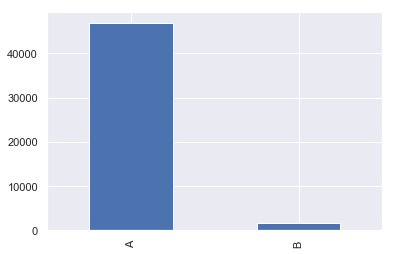

In [227]:
#Check the distribution
df['credit_score'].value_counts().sort_index().plot.bar()

### Derive the Past data

Now that we have the column that we want to predict, we turn our attention to creating our predictors that will be used to classify the datapoints. 

We commence by simply calculating the rounded level of debt for the past 6 months. 

In [228]:
timeseries_columns=[]
for i in range(5,-1,-1): #For 6 months in the past
  timeseries_columns+=['t'+str(i)]
  df['t'+str(i)]=df.groupby(['name'])['owed_months'].shift(i)
  df['t'+str(i)]=df['t'+str(i)]#.round(0) #We dont need to round for a Gaussian NB
#remove missing data (columns that are less than 6 months from final month of tenancy) 
df = df.dropna()

#Classify the past 6 month score
df['past_credit_score']=df.apply(credit_score, axis=1)

#Add the max and min owed
df['max_owed']=df[timeseries_columns].max(axis=1)
df['min_owed']=df[timeseries_columns].min(axis=1)
df.head(8)

,name,house_id,zip,payment_date,rent,owed,owed_months,credit_score,credit_score_short,t5,t4,t3,t2,t1,t0,past_credit_score,max_owed,min_owed
5,Aaron Huston,1.0,92194.0,2010-07-01,1720.0,0.0,0.0,A,A,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0
6,Aaron Huston,1.0,92194.0,2010-08-01,1720.0,0.0,0.0,A,A,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0
7,Aaron Huston,1.0,92194.0,2010-09-01,1720.0,1720.0,1.0,A,A,0.0,0.0,0.0,0.0,0.0,1.0,A,1.0,0.0
8,Aaron Huston,1.0,92194.0,2010-10-01,1720.0,1720.0,1.0,A,A,0.0,0.0,0.0,0.0,1.0,1.0,A,1.0,0.0
9,Aaron Huston,1.0,92194.0,2010-11-01,1720.0,1720.0,1.0,A,A,0.0,0.0,0.0,1.0,1.0,1.0,A,1.0,0.0
10,Aaron Huston,1.0,92194.0,2010-12-01,1720.0,1720.0,1.0,A,A,0.0,0.0,1.0,1.0,1.0,1.0,A,1.0,0.0
11,Aaron Huston,1.0,92194.0,2011-01-01,1720.0,1720.0,1.0,A,A,0.0,1.0,1.0,1.0,1.0,1.0,A,1.0,0.0
12,Aaron Huston,1.0,92194.0,2011-02-01,1720.0,1720.0,1.0,A,A,1.0,1.0,1.0,1.0,1.0,1.0,A,1.0,1.0


### Append the postode data

Now we add the standardized data from the IRS to each row based on their postcode

In [229]:
df['zip']=df['zip'].astype('int64')
df = pd.merge(df, df_geo, left_on='zip', right_on='ZIPCODE', how='left')
df=df.fillna(df.mean())
df.head(5)

,name,house_id,zip,payment_date,rent,owed,owed_months,credit_score,credit_score_short,t5,...,t1,t0,past_credit_score,max_owed,min_owed,ZIPCODE,population,earnings,salaries,marriages
0,Aaron Huston,1.0,92194,2010-07-01,1720.0,0.0,0.0,A,A,0.0,...,0.0,0.0,A,0.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604
1,Aaron Huston,1.0,92194,2010-08-01,1720.0,0.0,0.0,A,A,0.0,...,0.0,0.0,A,0.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604
2,Aaron Huston,1.0,92194,2010-09-01,1720.0,1720.0,1.0,A,A,0.0,...,0.0,1.0,A,1.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604
3,Aaron Huston,1.0,92194,2010-10-01,1720.0,1720.0,1.0,A,A,0.0,...,1.0,1.0,A,1.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604
4,Aaron Huston,1.0,92194,2010-11-01,1720.0,1720.0,1.0,A,A,0.0,...,1.0,1.0,A,1.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604


### Binarize the data


In [230]:
#Binarize the credit score
credit_binarizer = preprocessing.LabelBinarizer()
credit_binarizer.fit(df[['past_credit_score']])
binary_columns=credit_binarizer.transform(df[['past_credit_score']])
df['A']=binary_columns
df.head(5)

,name,house_id,zip,payment_date,rent,owed,owed_months,credit_score,credit_score_short,t5,...,t0,past_credit_score,max_owed,min_owed,ZIPCODE,population,earnings,salaries,marriages,A
0,Aaron Huston,1.0,92194,2010-07-01,1720.0,0.0,0.0,A,A,0.0,...,0.0,A,0.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
1,Aaron Huston,1.0,92194,2010-08-01,1720.0,0.0,0.0,A,A,0.0,...,0.0,A,0.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
2,Aaron Huston,1.0,92194,2010-09-01,1720.0,1720.0,1.0,A,A,0.0,...,1.0,A,1.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
3,Aaron Huston,1.0,92194,2010-10-01,1720.0,1720.0,1.0,A,A,0.0,...,1.0,A,1.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
4,Aaron Huston,1.0,92194,2010-11-01,1720.0,1720.0,1.0,A,A,0.0,...,1.0,A,1.0,0.0,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0


### Scale the data

In [231]:
#Create scalers for the input fields
rent_scaler = StandardScaler().fit(df['rent'].values.reshape(-1, 1))
owed_scaler = StandardScaler().fit(df['owed'].values.reshape(-1, 1))
min_owed_scaler = StandardScaler().fit(df['min_owed'].values.reshape(-1, 1))
max_owed_scaler = StandardScaler().fit(df['max_owed'].values.reshape(-1, 1))

df['rent']=rent_scaler.transform(df['rent'].values.reshape(-1, 1))
df['owed']=owed_scaler.transform(df['owed'].values.reshape(-1, 1))
df['min_owed']=min_owed_scaler.transform(df['min_owed'].values.reshape(-1, 1))
df['max_owed']=max_owed_scaler.transform(df['max_owed'].values.reshape(-1, 1))
df.head(5)

,name,house_id,zip,payment_date,rent,owed,owed_months,credit_score,credit_score_short,t5,...,t0,past_credit_score,max_owed,min_owed,ZIPCODE,population,earnings,salaries,marriages,A
0,Aaron Huston,1.0,92194,2010-07-01,0.708587,-0.540724,0.0,A,A,0.0,...,0.0,A,-0.769270,-0.137193,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
1,Aaron Huston,1.0,92194,2010-08-01,0.708587,-0.540724,0.0,A,A,0.0,...,0.0,A,-0.769270,-0.137193,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
2,Aaron Huston,1.0,92194,2010-09-01,0.708587,0.171371,1.0,A,A,0.0,...,1.0,A,-0.087708,-0.137193,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
3,Aaron Huston,1.0,92194,2010-10-01,0.708587,0.171371,1.0,A,A,0.0,...,1.0,A,-0.087708,-0.137193,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0
4,Aaron Huston,1.0,92194,2010-11-01,0.708587,0.171371,1.0,A,A,0.0,...,1.0,A,-0.087708,-0.137193,92117.92092,0.010261,-0.016097,-0.007373,0.34604,0


### Split the data

Given that we will use __Cross Validation__ we will only create a test and a train split of the data.

In [232]:
#Set the columns to be used
classifier_columns=['rent','owed_months','t0','t1','t2','t3','t4','t5','A','max_owed','min_owed',
                    'population','earnings','marriages']
label_columns=list('A')

#Split the data into x and y
x_all=df[classifier_columns]
y_all=df[['credit_score','credit_score_short']]

#Split the data in train and validate (shuffling is default True)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size = 0.25)

## Applying models

In this section, we will take 7 models and apply them to our split data. Where hyperparameter tunning is needed, we will utilize the __Cross Validation__ method over a range of parameter options.

### Gaussian NB

Validation: 0.9376093894780192  False Positive: 0.22169811320754718  False Negative: 0.05511895790720207


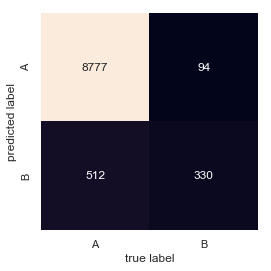

In [241]:
#Create and train the model
model = GaussianNB()
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']));

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['A','B'], yticklabels=['A','B'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Classification Tree

Here we try altering two parameters, the tree depth and the max leaf nodes. From the validation curves below, we observe that both produce similar results and therfore we prefer the tree depth limit.

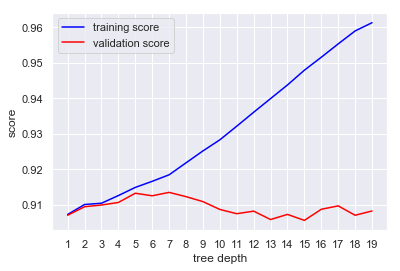

In [175]:
depth=range(1,20)

#Cross validate with 7 fold variating the max_depth
training_score, validation_score = validation_curve(DecisionTreeClassifier(), 
                                           x_train[classifier_columns], 
                                           np.ravel(y_train['credit_score']),
                                           'max_depth', depth, cv=7)

#Plot the validation and training scores
plt.plot(depth, np.median(training_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(validation_score, 1), color='red', label='validation score')
plt.xticks(depth)
plt.legend(loc='best')
plt.xlabel('tree depth')
plt.ylabel('score');

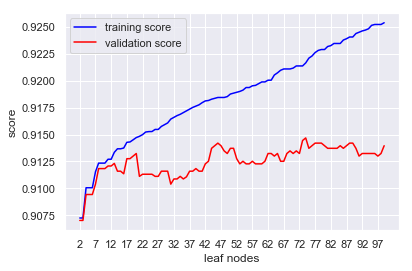

In [176]:
max_leaf=range(2,100)

#Cross validate with 7 fold variating the max_leaf
training_score, validation_score = validation_curve(DecisionTreeClassifier(), 
                                           x_train[classifier_columns], 
                                           np.ravel(y_train['credit_score']),
                                           'max_leaf_nodes', max_leaf, cv=7)
#Plot the validation and training scores
plt.plot(max_leaf, np.median(training_score, 1), color='blue', label='training score')
plt.plot(max_leaf, np.median(validation_score, 1), color='red', label='validation score')
plt.xticks(max_leaf[0::5])
plt.legend(loc='best')
plt.xlabel('leaf nodes')
plt.ylabel('score');

Validation: 0.9170184289097086  False Positive: 0.5668604651162791  False Negative: 0.0031186278037663427


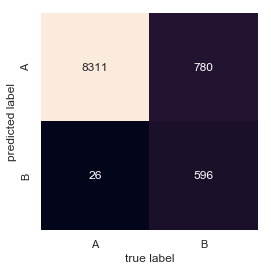

In [177]:
#Create and train the model
model = DecisionTreeClassifier(max_depth=5)
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']));

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['A','B'], yticklabels=['A','B'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### K-Nearest Neighbors

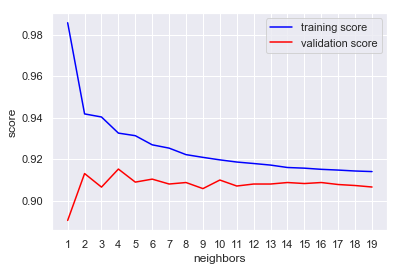

In [178]:
#set the range we want to test
k_range=range(1,20)

#Cross validate with 7 fold variating the n_neighbors
training_score, validation_score = validation_curve(KNeighborsClassifier(), 
                                           x_train[classifier_columns], 
                                           np.ravel(y_train['credit_score']),
                                           'n_neighbors', k_range, cv=7)
#Plot the validation and training scores
plt.plot(depth, np.median(training_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(validation_score, 1), color='red', label='validation score')
plt.xticks(depth)
plt.legend(loc='best')
plt.xlabel('neighbors')
plt.ylabel('score'); 

Validation: 0.9142386492329867  False Positive: 0.5  False Negative: 0.018777658174859466


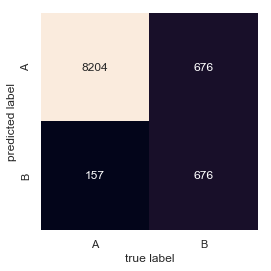

In [185]:
#Create and train the model
model = KNeighborsClassifier(n_neighbors=4)
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']));

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['A','B'], yticklabels=['A','B'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Support Vector Machine

Validation: 0.9119736435704726  False Positive: 0.5739644970414202  False Negative: 0.009448630546585337


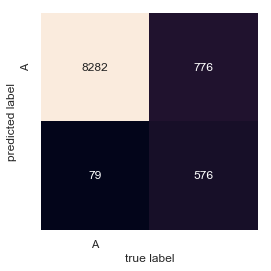

In [186]:
#Create and train the model
model = SVC(gamma='auto')
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']));

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=label_columns, yticklabels=label_columns)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Bagging Trees (Random Forest)

Validation: 0.9120765983733141  False Positive: 0.5828402366863905  False Negative: 0.007893792608539648


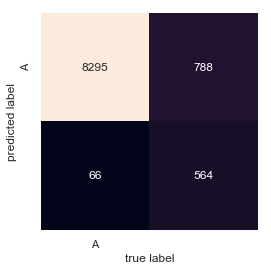

In [188]:
#Create and train the model
model= RandomForestClassifier(n_estimators=500, max_depth=5, n_jobs=-1)
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']))

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=label_columns, yticklabels=label_columns)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Boosting


Validation: 0.9259754967569237  False Positive: 0.3779585798816568  False Negative: 0.024877407008731013


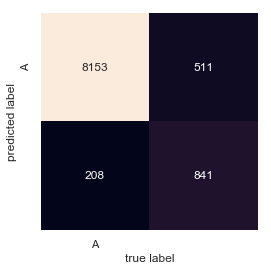

In [189]:
#Create and train the model
model= AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=100, algorithm='SAMME.R',learning_rate=0.5)
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']))

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=label_columns, yticklabels=label_columns)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Voting

Validation: 0.9131061464017296  False Positive: 0.5850591715976331  False Negative: 0.00633895467049396


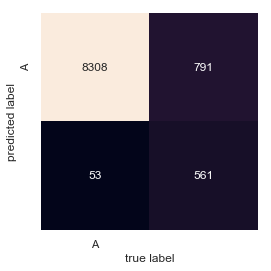

In [190]:
#Define models in voting
nb_model= GaussianNB()
knn_model= KNeighborsClassifier(n_neighbors=4)
svm_model = SVC(gamma='auto')
tree_model = DecisionTreeClassifier(max_depth=5)
estimators=[('nb_model',nb_model),('knn_model',knn_model),('svm_model',svm_model),('tree_model',tree_model)]

#Create and train the voting model
model=VotingClassifier(estimators=estimators,voting='hard')
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']))

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=label_columns, yticklabels=label_columns)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Model comparison

The below table consolidates the results obtained for the models in this section. Please note that in case this notebook is being run separately, the results may vary due to the randomized data split.

<table align="center">
  <tr>
    <th>Model</th>
    <th>Validation Accuracy</th>
    <th>False Positive <br> Bad tenant classed good</th>
    <th>False Negative <br> Good tenant classed bad</th>
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>86.97%</td>
    <td>31.68%</td>
    <td>9.94%</td>
  </tr>
  <tr>
    <td>Classification Tree</td>
    <td>91.7%</td>
    <td>56.68%</td>
    <td>0.31%</td>
  </tr>
  <tr>
    <td>K-Nearest Neighbors</td>
    <td>91.92%</td>
    <td>50%</td>
    <td>1.87%</td>
  </tr>
  <tr>
    <td>Support Vector Machines</td>
    <td>91.19%</td>
    <td>57.39%</td>
    <td>0.94%</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>91.2%</td>
    <td>58.28%</td>
    <td>0.78%</td>
  </tr>
  <tr>
    <td>AdaBoost with Trees</td>
    <td>92.59%</td>
    <td>37.79%</td>
    <td>2.48%</td>
  </tr>
  <tr>
    <td>Voting NB, KNN, SVM and Tree</td>
    <td>91.31%</td>
    <td>58.50%</td>
    <td>0.63%</td>
  </tr>
<table align="center">
    
As discussed during the hypothesis setting, although the accuracy is important, we will pick the model that gives us the lowest false positive score. This is, the model that is best at identifying the tenants who are high risk, even if we sacrifice incorrectly classifiyng some of the low risk. 

As can be seen from the above data, the __Naive Bayes Classifier__ is the best performer in False Positives and therefore we establish it as our lead model.

### Parameter evaluation

Now that we have found our ideal model, we want to try for different parameters. The following code loops around each individual parameter available and creates a Naive Bayes model that excludes that parameter. This should identify those parameters that by removing them would create better models

In [198]:
for v in classifier_columns:
    temp_set=set(classifier_columns)
    temp_set.remove(v)
    model = GaussianNB()
    model.fit(x_train[list(temp_set)], np.ravel(y_train));

    #Predict the test data
    y_predict=model.predict(x_test[list(temp_set)])

    #Check accuracy & precision
    mat = confusion_matrix(y_test, y_predict)
    validation_accuracy=round(accuracy_score(y_test, y_predict),2)
    fp=round(mat.T[0][1]/(mat.T[0][1]+mat.T[1][1]),2)
    fn=round(mat.T[1][0]/(mat.T[1][0]+mat.T[0][0]),2)
    print(v,"\t -Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

rent 	 -Validation: 0.87  False Positive: 0.32  False Negative: 0.1
owed_months 	 -Validation: 0.87  False Positive: 0.34  False Negative: 0.09
t0 	 -Validation: 0.87  False Positive: 0.34  False Negative: 0.09
t1 	 -Validation: 0.87  False Positive: 0.34  False Negative: 0.09
t2 	 -Validation: 0.87  False Positive: 0.34  False Negative: 0.09
t3 	 -Validation: 0.87  False Positive: 0.34  False Negative: 0.09
t4 	 -Validation: 0.87  False Positive: 0.34  False Negative: 0.09
t5 	 -Validation: 0.87  False Positive: 0.32  False Negative: 0.1
A 	 -Validation: 0.85  False Positive: 0.27  False Negative: 0.13
max_owed 	 -Validation: 0.87  False Positive: 0.33  False Negative: 0.09
min_owed 	 -Validation: 0.87  False Positive: 0.32  False Negative: 0.1
population 	 -Validation: 0.87  False Positive: 0.32  False Negative: 0.1
earnings 	 -Validation: 0.87  False Positive: 0.33  False Negative: 0.1
marriages 	 -Validation: 0.87  False Positive: 0.32  False Negative: 0.1


Based on this information, we propose a model with rent, owed months, 6 months of past debt, maximum owed, minimum owed, population, earnings and marriages

Validation: 0.852752321630804  False Positive: 0.27076226415094338  False Negative: 0.12720734201743998


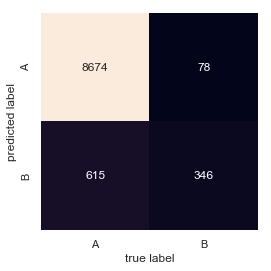

In [247]:
#New Columns
classifier_columns=['rent','owed_months','t0','t1','t2','t3','t4','t5','max_owed','min_owed',
                    'population','earnings','marriages']

#Create and train the model
model = GaussianNB()
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score']));

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['A','B'], yticklabels=['A','B'])
plt.xlabel('true label')
plt.ylabel('predicted label');

We can observe that the new false positive rate is, 27.07%, is better than the previous record of 31.68%. Therefore we have reached our final model and can __accept the hypothesis that the false positive rate is less than 30%__

## Short Term Risk

We now take at our ideal model and parameters and create a model to predict the short term risk, i.e. the high risk/low risk classification for the next 3 months (instead of the original 6 months). We note that we are not changing any of the data, we are simply predicting a different label that has been previosly created

Validation: 0.928652321630804  False Positive: 0.18396226415094338  False Negative: 0.06620734201743998


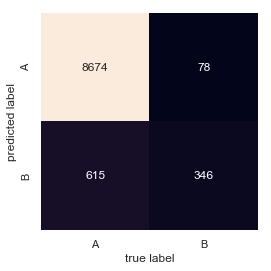

In [248]:
#Create and train the model
model = GaussianNB()
model.fit(x_train[classifier_columns], np.ravel(y_train['credit_score_short']));

#Predict the test data
y_predict=model.predict(x_test[classifier_columns])

#Check accuracy & precision
mat = confusion_matrix(y_test['credit_score_short'], y_predict)
validation_accuracy=accuracy_score(y_test['credit_score_short'], y_predict)
fp=mat.T[0][1]/(mat.T[0][1]+mat.T[1][1])
fn=mat.T[1][0]/(mat.T[1][0]+mat.T[0][0])
print("Validation:",validation_accuracy," False Positive:",fp," False Negative:",fn)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['A','B'], yticklabels=['A','B'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In a very short glance, we can observe that predicting risk over 3 months, is significantly more accurate than predicting over 6 months. This shouldnt be surprising as long term predictions are typically harder to make.

## Conclusion

In this exercise we used two data sources, the history of payents and IRS data at the postcode level. In the first part of the exercise we discovered inconsistencies in all dates from the rental data. In particular, the date of birth suggested a large proportion of people paying were under 18 years of age, not yet born, or born over 100 years ago, therefore, we decided to drop the column. The payment date was found to contain mix formats, and thus we had to create a function to decide on a date format for each house based on the total history of dates. The rest of the variables, including those from the postal set were standard scaled.

The second part of the assignment consisted of creating a label for either low risk or high risk tenant, A and B respectively. Here we used the past 6 months of data and classified each data point as A or B depending on the slope of amount of months owed as well as the and latest debt position. We also pivoted the 6 months of debt standings previous to the prediction months and merged the postcode data onto a single set.

In the third part of this notebook, we created 7 different classification models and derived the performance meassure for each against our dataset. Where parameter tunning was necessary, we used the cross validation method to find the setting that maximised accuracy. We summarised the scores of all the models on a single table presented in the previous section. Here, we decided that the most critical measure was the False Positive rate, this given the fact that we are inerested in the model that minimises the amount of times that a bad payer is classified as good. The winning model was Naive Bayes, with an accuracy score of 86.97%, a false positive rate of 31.68% and 9.94% false negatives.

A further step was to eliminate the variables that were not needed. We did this by iterating over every variable and calculating the score for our selected Naive Bayes model without such parameter. This lead us to drop the past 6 month credit rating parameter which acted as a proxy for past payment history. The simpler model resulted in an improvement of scores, with the new accuracy being 85.27%, a false positive rate at 27.07% and 6.62% false negatives.

However, the most significant improvement to our models, is to use a shorter prediction time horizon. By switching from a 6 month to a 3 month future window we were able to acheive 92.86% accuracy, 18.39% fase positives and 12.72% false negatives. It is a general rule that short term predictions are more accurate than long term, and this experiment supports that conclusion.

We conclude that given the limited data, an accuracy of 92.86% and a false positive rate of 12.72% is a successful result. This is, we accept the hypothesis that _Given the history of payments for an individual at a specific point in time, it is possible to accurately estimate the probability of falling into arrears_. However, we aknowledge that this model is not yet good enough for utilising in a production environment for two reasons, accuracy and simplicity.

In terms of accuracy, we believe that the best strategy for improving scores is enriching the dataset. We expect that it would be possible to find further information about the area of the house as well as the tenant that can lead to better predictions. Therefore a key recommendation for the project is to look for alternative data sources.

In terms of simplicity, we have only classified tenants into low risk or high risk, which allows the landlord to decide if they should accept a new tenant or not. However, it is a possible scenario, that insted of a fixed label, the landlord might want to have a numerical value that allows her to expand the actionables. For example, if the probability of becoming a bad tenant grows, then warning letter and finanacial advice can be issued to prevent them falling in arrears. Therefore our second key recommendation is to explore the use of probability and regression models instead of classifiers.

Lastly, we recommend that the landlord use the short term predictions wherever possible given the higher accuracy. An example could be to utilize the short term prediction to decide who to provide financial advice to and the long term prediction to decide which individuals will need more thorough background checks before moving into a property.